In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
tf.__version__

'2.0.0'

In [3]:
PATH = '/Users/stevenneira/Desktop/Work/studing/FlowersIA/'
INPATH = PATH + 'inImages'
OUTPATH = PATH + 'outImages'
CHECKP = PATH + 'checkpoints'
outputPath = PATH + 'output/'
IMG_WIDTH = 256
IMG_HEIGTH = 256

In [4]:
listUrls = os.listdir(INPATH)
listOutUrls = os.listdir(INPATH)
imgUrls = np.copy(listUrls)
np.random.shuffle(imgUrls)
n = 500;
train_n = round(n * 0.80);

tr_images = imgUrls[:train_n]
ts_images = imgUrls[train_n:n]
print(len(ts_images),len(tr_images))
print(len(listUrls),len(listOutUrls))

100 400
8189 8189


In [6]:
#Reescalar images
def resize(in_img, out_img, heigth, widht):
    in_img = tf.image.resize(in_img, [heigth,widht])
    out_img = tf.image.resize(out_img, [heigth,widht])
    return in_img, out_img

#Normalize images [-1,1] range
def normalize(in_img, out_img, heigth, widht):
    in_img = (in_img/127.5) - 1
    out_img = (out_img/127.5) - 1
    return in_img, out_img

def random_jitter(in_img, out_img):
    in_img, out_img = resize(in_img,out_img, 286,286)
    stacked_image = tf.stack([in_img,out_img], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2,IMG_HEIGTH,IMG_WIDTH, 3])
    in_img, out_img = cropped_image[0],cropped_image[1]
    
    if tf.random.uniform(()) > 0.5:
        in_img = tf.image.flip_left_right(in_img)
        out_img = tf.image.flip_left_right(out_img)
        
    return in_img, out_img;
        
def load_image(filename, augment=True):
    in_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[...,:3]
    out_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[...,:3]
    in_img, out_img = resize(in_img,out_img, IMG_HEIGTH, IMG_WIDTH)
    if augment:
        in_img, out_img = random_jitter(in_img, out_img)
        
    in_img, out_img = normalize(in_img, out_img,IMG_HEIGTH,IMG_WIDTH)
    return in_img, out_img;

def load_train_image(filename):
    return load_image(filename, True)
def load_test_image(filename):
    return load_image(filename, False)

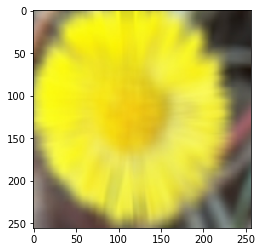

In [7]:
imgR = ((load_train_image(tr_images[0])[0])+1 )/2
plt.imshow(imgR) 

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_images)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_images)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [25]:

from tensorflow.keras.layers import *
from tensorflow.keras import *

generator_optimazer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimazer = optimizers.Adam(2e-4, beta_1=0.5)

def downsample(filters, apply_batchnorm=True):
    result = Sequential()
    initializer = tf.random_normal_initializer(0, 0.02)
    # capa convolucional
    """conv2d = Conv2D(filters,
                      kernel_size= 4,
                      strides=2,
                      padding="same",
                      kernel_initializer=initializer,
                      use_bias=not apply_batchnorm)"""
    #result.add(conv2d)
    
    if apply_batchnorm:
        #capa batch normalization
        result.add(BatchNormalization())
    
    #capa activación
    result.add(LeakyReLU())
    
    
    return result;

downsample(64)

In [26]:
def upsample(filters, apply_dropout=False):
    result = Sequential()
    initializer = tf.random_normal_initializer(0,0.02)
    # capa convolucional
    """laTranspuesta = Conv2DTranspose(filters,
                              kernel_size= 4,
                              strides=2,
                              padding="same",
                              kernel_initializer=initializer,
                              use_bias=False)"""
    #result.add(laTranspuesta)
    #capa batch normalization
    result.add(BatchNormalization())
    
    if apply_dropout:
        result.add(Dropout(0.5))

    
    #capa activación
    result.add(ReLU())
    
    
    return result;

upsample(64)

In [27]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[None, None,3])
    down_stack = [
        downsample(64, apply_batchnorm=False), # (bs, 128,128,64)
        downsample(128),                       # (bs, 64,64,128)
        downsample(256),                       # (bs, 32,32,216)
        downsample(512),                       # (bs, 16,16,512)
        downsample(512),                       # (bs, 8,8,512)
        downsample(512),                       # (bs, 4,4,512)
        downsample(512),                       # (bs, 2,2,512)
        downsample(512),                       # (bs, 1,1,512)
    ]
    
    
    up_stack = [
        upsample(512, apply_dropout=True),  # (bs, 2,2,1024)
        upsample(512, apply_dropout=True), # (bs, 4,4,1024)
        upsample(512, apply_dropout=True), # (bs, 8,8,1024)
        upsample(512),                      # (bs, 16,16,1024)
        upsample(256),                      # (bs, 32,32,512)
        upsample(128),                      # (bs, 64,64,256)
        upsample(64),                      # (bs, 128,128,128)
    ]
    
    initializer = tf.random_normal_initializer(0,0.02)
    last = Conv2DTranspose(filters=3,
                           kernel_size= 4,
                           strides=2,
                           padding="same",
                           kernel_initializer=initializer,
                           activation="tanh")
    x = inputs
    s = []
    concat = Concatenate()
    for down in down_stack:
        print('dow',down)
        x = down(x)
        print('x down',x)
        #s.append(x)
        
    s = reversed(s)
    
    #for up, sk in zip(up_stack, s):
    for up in up_stack:
        x = up(x)
        print('x up',x)
        #x = concat([x,sk])
        
        
        
    last =  last(x)
    return Model(inputs =inputs, outputs= x)



generator = Generator()

dow <tensorflow.python.keras.engine.sequential.Sequential object at 0x657a6d5c0>
x down Tensor("sequential_43/Identity:0", shape=(None, None, None, 3), dtype=float32)
dow <tensorflow.python.keras.engine.sequential.Sequential object at 0x657a6d7f0>
x down Tensor("sequential_44/Identity:0", shape=(None, None, None, 3), dtype=float32)
dow <tensorflow.python.keras.engine.sequential.Sequential object at 0x657a6db38>
x down Tensor("sequential_45/Identity:0", shape=(None, None, None, 3), dtype=float32)
dow <tensorflow.python.keras.engine.sequential.Sequential object at 0x657a62128>
x down Tensor("sequential_46/Identity:0", shape=(None, None, None, 3), dtype=float32)
dow <tensorflow.python.keras.engine.sequential.Sequential object at 0x657a626d8>
x down Tensor("sequential_47/Identity:0", shape=(None, None, None, 3), dtype=float32)
dow <tensorflow.python.keras.engine.sequential.Sequential object at 0x657a62c88>
x down Tensor("sequential_48/Identity:0", shape=(None, None, None, 3), dtype=float32

In [28]:
imgR = ((load_train_image(tr_images[0])[0])+1 )/2
salida = generator(imgR, training=False)
print(salida)

InvalidArgumentError: input must be 4-dimensional[256,256,3] [Op:FusedBatchNormV3]

In [18]:
def Discriminator():
    ini = Input(shape=[None, None,3], name="input_img")
    gen = Input(shape=[None, None,3], name="generator_img")
    con = concatenate([ini,gen])
    
    initializer = tf.random_normal_initializer(0,0.02)
    down1 = downsample(64, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)
    
    last = Conv2D(filters=1,
                 kernel_size=4,
                 strides=1,
                 kernel_initializer=initializer,
                 padding="same")(down4)
    return Model(inputs=[ini,gen], outputs=last)

discriminator = Discriminator()



In [19]:
loss_object = losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [22]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gen_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gen_loss + ( LAMBDA * l1_loss)
    return total_gen_loss


In [23]:
def generate_images(model, test_input, tar, save_filename= False, display_img=True):
    prediction = model(test_input, training= True)
    
    if save_filename:
        preprocessing.image.save_img(PATH + outputPath + save_filename + '.jpg', prediction[0,...])
    plt.figure(figsize=(10,10))
    
    display_list=[test_input[0], tar[0], prediction[0]]
    title=["Input Image","Ground Truth", "Predicted Image"]
    if display_img:
        for i in range(3):
            plt.subplot(1,3,i+1)
            plt.title(title[i])
            # getting the pixel values between 0 and 1 to plot it
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
    
    plt.show()

In [24]:
@tf.function()
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        
        output_image = generator(input_image, training=True)
        output_gen_discr = discriminator([output_image, input_image], training=True)
        output_target_discr = discriminator([target, input_image], training=True)
        
        discr_loss = discriminator_loss(output_target_discr, output_gen_discr)
        gen_loss = generator_loss(output_gen_discr, output_image, target)
        
        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_grads = discr_tape.gradient(discr_loss,discriminator.trainable_variables)
        
        generator_optimazer.apply_gradients(zip(generator_grads, generator.trainable_variables))
        discriminator_optimazer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [25]:
from IPython.display import clear_output

def train(dataset, epochs):
    for epoch in range(epochs):
        
        imgi = 0
        for input_image, target in train_dataset.take(len(tr_images)):
            print('epoch:'+ str(epoch)+'-Train:'+str(imgi)+'/'+str(len(tr_images)))
            imgi+=1;
            train_step(input_image, target)
            clear_output(wait=True)
            

        
        
        imgi = 0
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(imgi) + '-' + str(epoch), display_img=True)
            imgi+=1;
                   
        
        

In [ ]:
train(train_dataset, 2)

epoch:0-Train:0/400
